In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 6.3MB/s 


In [ ]:
#Importación de librerías necesarias

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pyunpack import Archive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
#Importamos las librerías de costumbre
import numpy as np
import pandas as pd
#Instalamos la librería que nos va a permitir bajar de drive
!pip install gdown
import gdown
#Colocamos la URL del archivo
url = 'https://drive.google.com/uc?id=1LHK1UqsOZMlF9lFuMeRApw6P5mkkexnM'
#Colocamos el nombre al archivo donde la información será guardada
Nombre = 'TipoVehiculo.rar'
#Lo descargamos
gdown.download(url,Nombre,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1LHK1UqsOZMlF9lFuMeRApw6P5mkkexnM
To: /content/TipoVehiculo.rar
349MB [00:03, 98.3MB/s]


'TipoVehiculo.rar'

In [ ]:
#Descompresión de las imágenes
os.mkdir('dataset')
Archive('TipoVehiculo.rar').extractall('dataset/')

In [ ]:
#Se cargan los conjustos de imágenes y se reescalan

train_dir = os.path.join('dataset/TipoVehiculo')
validation_dir = os.path.join('dataset/TipoVehiculo')

BATCH_SIZE = 15
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')


Found 17542 files belonging to 8 classes.
Found 17542 files belonging to 8 classes.


In [ ]:
#Configuración de los conjuntos de datos para mejor el rendimiento en el entrenamiento usando la API tf.data

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
#Usar aumento de datos

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Cambiar la escala de los valores de píxeles de las imágenes 

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5)

In [ ]:
# Creación sel modelo base a partir del modelo previamente entrenado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Congelar la base convolucional

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#Agregar un encabezado de clasificación

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8,activation='softmax',kernel_initializer='random_normal',bias_initializer='zeros')

In [ ]:
import json

def write_json(dataz, filename): 
	with open(filename,'w') as f: 
	    json.dump(dataz, f, indent=4) 

data = []

with open('history.json', 'w') as file:
    json.dump(data, file, indent=4)

In [ ]:
#Compilar el modelo y entrenarlo

os.mkdir('modelos')
base_learning_rate = 0.0001
history = []
contador = 0

for i in range(1,101):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    mcp_save = ModelCheckpoint('/content/modelos/transfer_learning_TV_'+str(i)+'.hdf5', save_best_only=True, monitor='val_loss', mode='min',save_weights_only=False)
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history.append(model.fit(train_dataset,epochs=100,callbacks=[mcp_save],validation_data=validation_dataset)) 

    with open('history.json') as json_file: 
	    datay = json.load(json_file) 
     
	    temp = datay

	    y = { 'accuracy': history[contador].history['accuracy'],
            'loss': history[contador].history['val_loss']
      }        		     

	    temp.append(y) 
    write_json(datay, 'history.json')  
 
    contador = contador + 1

    del model

Epoch 1/100
1170/1170 [==============================] - 70s 52ms/step - loss: 2.2248 - accuracy: 0.2786 - val_loss: 1.3803 - val_accuracy: 0.5604
Epoch 2/100
1170/1170 [==============================] - 61s 52ms/step - loss: 1.6271 - accuracy: 0.4572 - val_loss: 1.1727 - val_accuracy: 0.6463
Epoch 3/100
1170/1170 [==============================] - 62s 53ms/step - loss: 1.4204 - accuracy: 0.5326 - val_loss: 1.0479 - val_accuracy: 0.6920
Epoch 4/100
1170/1170 [==============================] - 61s 52ms/step - loss: 1.2959 - accuracy: 0.5809 - val_loss: 0.9655 - val_accuracy: 0.7158
Epoch 5/100
1170/1170 [==============================] - 61s 52ms/step - loss: 1.2100 - accuracy: 0.6134 - val_loss: 0.9047 - val_accuracy: 0.7300
Epoch 6/100
1170/1170 [==============================] - 62s 53ms/step - loss: 1.1296 - accuracy: 0.6331 - val_loss: 0.8594 - val_accuracy: 0.7394
Epoch 7/100
1170/1170 [==============================] - 62s 53ms/step - loss: 1.0920 - accuracy: 0.6433 - val_loss: 0

KeyboardInterrupt: ignored

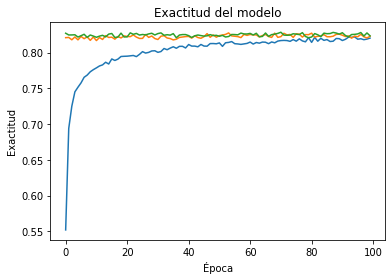

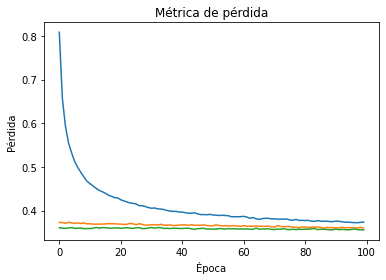

In [ ]:
#Visualización de los resultados en gráficas

for i in range(len(history)):
  plt.plot(history[i].history['accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.show()
# "Loss"
for i in range(len(history)):
  plt.plot(history[i].history['val_loss'])
plt.title('Métrica de pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [ ]:
#calculo del porcentajes de validación 

best_val_history = []
for i in range(1,3):
    model = load_model('modelos/transfer_learning_'+str(i)+'.hdf5')
    best_val_history.append(model.evaluate(validation_dataset))
    del model

1170/1170 [==============================] - 31s 26ms/step - loss: 0.3598 - accuracy: 0.8752


In [ ]:
#Calculo de promedios de validación y pérdida 

prom_loss = 0.0;
prom_acc = 0.0;
for i in range(len(best_val_history)):
    prom_loss = prom_loss + best_val_history[i][0]
    prom_acc = prom_acc + best_val_history[i][1]

prom_loss = prom_loss / len(best_val_history)
prom_acc = prom_acc / len(best_val_history)

print(prom_loss)
print(prom_acc)

0.43857941031455994
0.8521474599838257


In [ ]:
import shutil
shutil.make_archive("modelos_tipo", 'zip', "modelos")

'/content/modelos_tipo.zip'